In [1]:
import gudhi as gd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pickle


from pygenstability import plotting
from pygenstability.contrib.optimal_scales import *
from pygenstability.pygenstability import _evaluate_NVI

In [2]:
import sys
from pathlib import Path

module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

from msfiltration import MSF

In [3]:
root_fig = '/home/tc/OneDrive/Software/MSFiltration/figures/'

In [4]:
#plt.rcParams.update({'font.size': 20})

# Generate multiscale SBM

In [5]:
from scipy.linalg import block_diag

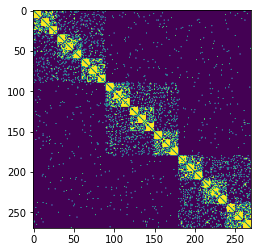

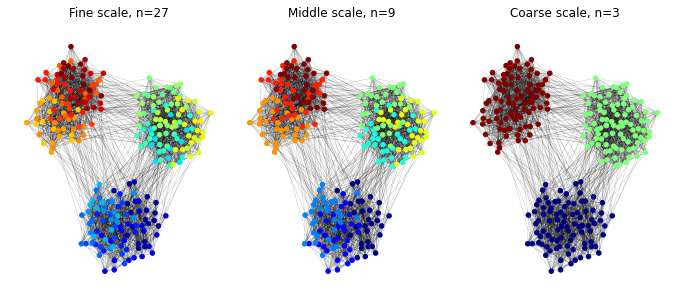

In [6]:
def block(n, th, rng):
    A = rng.uniform(0, 1, (n, n))
    A[A < th] = 0.0
    A[A > th] = 1.0
    A = (A + A.T) / 2
    return A


# define size and strength of multiscale structure
n0 = 270
th0 = 0.995

n1 = 3
th1 = 0.95

n2 = 9
th2 = 0.8

n3 = 27
th3 = 0.2

# construct adjacency matrix
rng = np.random.RandomState(42)
A = block(n0, th0, rng)
A += block_diag(*[block(int(n0 / n1), th1, rng) for i in range(n1)])
A += block_diag(*[block(int(n0 / n2), th2, rng) for i in range(n2)])
A += block_diag(*[block(int(n0 / n3), th3, rng) for i in range(n3)])

# binarized
A[A > 0] = 1

# remove self-loops
A -= np.diag(np.diag(A))

# plot matrix
plt.figure()
plt.imshow(A)
plt.savefig(root_fig +'adjacency_matrix.pdf', bbox_inches='tight')

# Multiscale structure
coarse_scale_id = np.zeros(n0)
middle_scale_id = np.zeros(n0)
fine_scale_id = np.zeros(n0)

for i in range(n1):
    coarse_scale_id[(i * n0 // n1) : ((i + 1) * n0 // n1)] = i

for i in range(n2):
    middle_scale_id[(i * n0 // n2) : ((i + 1) * n0 // n2)] = i

for i in range(n3):
    fine_scale_id[(i * n0 // n3) : ((i + 1) * n0 // n3)] = i

# Create nx graph
G = nx.from_numpy_array(A)

# Compute spring layout
pos = nx.layout.spring_layout(G, seed=2)

# Plot multiscale graph structure
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
fig.subplots_adjust(hspace=0.4, wspace=0)


nx.draw(
    G,
    ax=axes[0],
    pos=pos,
    node_size=20,
    arrows=False,
    width=0.1,
    node_color=fine_scale_id,
    cmap="jet",
)
axes[0].set(title=r"Fine scale, n=27")

nx.draw(
    G,
    ax=axes[1],
    pos=pos,
    node_size=20,
    arrows=False,
    width=0.1,
    node_color=middle_scale_id,
    cmap="jet",
)
axes[1].set(title=r"Middle scale, n=9")

nx.draw(
    G,
    ax=axes[2],
    pos=pos,
    node_size=20,
    arrows=False,
    width=0.1,
    node_color=coarse_scale_id,
    cmap="jet",
)
axes[2].set(title=r"Coarse scale, n=3")

plt.savefig(root_fig +'Multiscale_Structure.pdf', dpi=fig.dpi,bbox_inches='tight')

In [7]:
G.number_of_nodes()

270

In [8]:
G.number_of_edges()

3473

# Markov Stability filtration - full OOP framework


In [9]:
# Set MS parameters
n_time = 200
min_time = -1.5
max_time = 0.5

In [10]:
# initialise MSF object
msf = MSF()

# run MS analysis, build filtration and compute PH
msf.fit_transform(A,min_time,max_time,n_time,with_ttprime=True,with_optimal_scales=True)

Running Markov Stability analysis ... 


100%|██████████| 200/200 [01:10<00:00,  2.82it/s]


Building filtration ...


100%|██████████| 200/200 [00:06<00:00, 29.53it/s] 


Computing persistence ... 


filtration took 3:14

### Results from Markov Stability analysis

In [11]:
all_results = msf.ms_results

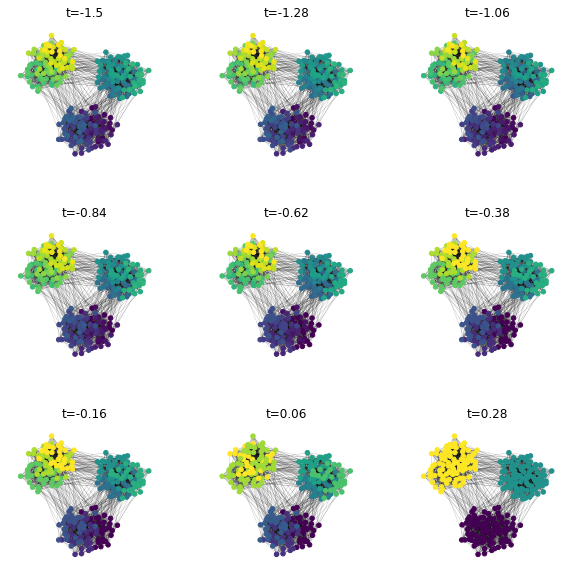

In [12]:
# Get times
times = all_results['times']
log_times = np.log10(all_results['times'])
n_time = all_results["run_params"]["n_time"]

# Get information about communities
community_id = all_results['community_id']
n_communities  = all_results['number_of_communities']

fig, axes = plt.subplots(3, 3, figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, ax in enumerate(axes.flat):
    
    time = int(i*len(times)/9)
    
    nx.draw(G, ax=ax,pos=pos, node_size = 20, arrows=False, width = 0.1,
            node_color = community_id[time])
    ax.set(title=r't={}'.format(np.around(log_times[time],2)))
plt.show()

[-1.28894472 -0.76633166 -0.24371859  0.31909548]


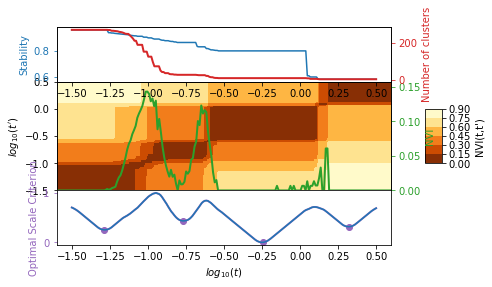

In [13]:
# select optimal scales
identify_optimal_scales(all_results,criterion_threshold=0.2,window_size=10)
selected_scales = log_times[all_results['selected_partitions']]
print(selected_scales)
plotting.plot_scan(all_results)
plt.savefig(root_fig +'MS_Scan.pdf',bbox_inches='tight')

In [14]:
selected_paritions = all_results['selected_partitions'][1:]

n_communities = [len(np.unique(all_results['community_id'][i])) for i in range(len(times))]

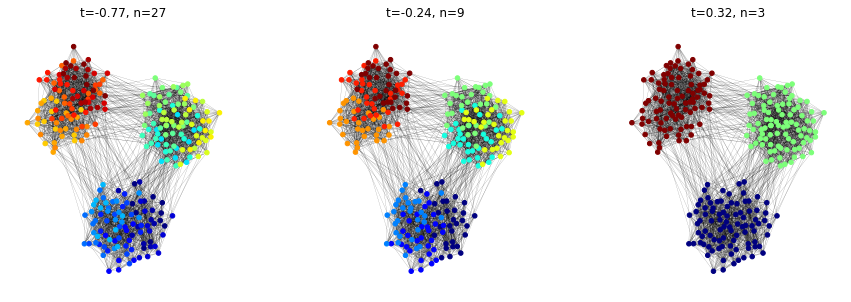

In [15]:
fig, axes = plt.subplots(1, len(selected_paritions), figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, ax in enumerate(axes.flat):
    
    time = selected_paritions[i]
    
    nx.draw(G, ax=ax,pos=pos, node_size = 20, arrows=False, width = 0.1,
            node_color = community_id[time],cmap = 'jet')
    ax.set(title=r't={}, n={}'.format(np.around(log_times[time],2), n_communities[time]))

plt.savefig(root_fig +'Partitions_ScaleCrit.pdf', dpi=fig.dpi,bbox_inches='tight')

### Persistent homology

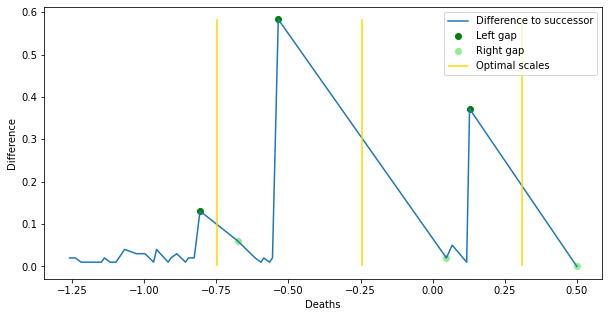

array([ 75, 125, 180])

In [16]:
# Select optimal scales
msf.select_scales(threshold_abs=0.13,min_gap_width=0.13,with_plot=True)
msf.optimal_scales

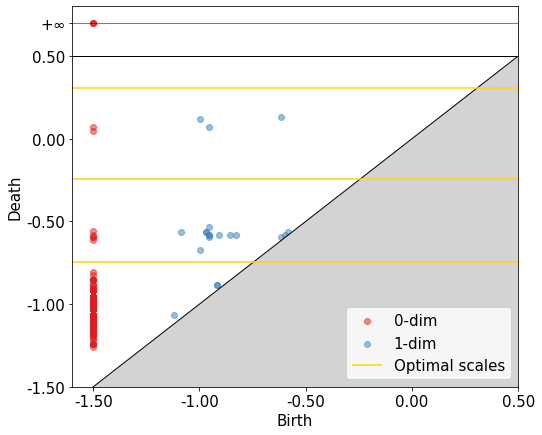

In [23]:
# Plot persistence diagram with optimal scales
ax = msf.plot_persistence_diagram()
plt.savefig(root_fig +'PD_SBM.pdf',bbox_inches='tight')

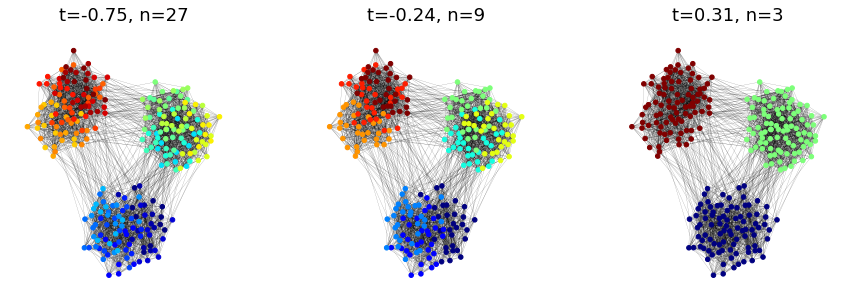

In [19]:
fig, axes = plt.subplots(1, len(msf.optimal_scales), figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, ax in enumerate(axes.flat):
    
    time = msf.optimal_scales[i] 
    
    nx.draw(G, ax=ax,pos=pos, node_size = 20, arrows=False, width = 0.1,
            node_color = community_id[time],cmap = 'jet')
    ax.set(title=r't={}, n={}'.format(np.around(log_times[time],2), n_communities[time]))

plt.savefig(root_fig +'Partitions_PH.pdf', dpi=fig.dpi,bbox_inches='tight')

# Compare optimal partitions to ground truth

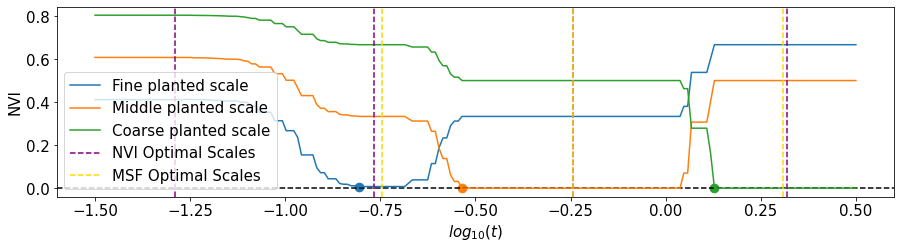

In [21]:
# compare MS partitions to ground truth with NVI
NVI_scores_fine = np.array(
    [
        _evaluate_NVI([0, i], [fine_scale_id] + all_results["community_id"])
        for i in range(1, n_time + 1)
    ]
)
NVI_scores_middle = np.array(
    [
        _evaluate_NVI([0, i], [middle_scale_id] + all_results["community_id"])
        for i in range(1, n_time + 1)
    ]
)
NVI_scores_coarse = np.array(
    [
        _evaluate_NVI([0, i], [coarse_scale_id] + all_results["community_id"])
        for i in range(1, n_time + 1)
    ]
)



# plot lower bound
fig, ax = plt.subplots(1, figsize=(15, 3.5))
ax.axhline(0, c="k", ls="--")

# plot NVI scores
ax.plot(log_times, NVI_scores_fine, label="Fine planted scale")
ax.plot(log_times, NVI_scores_middle, label="Middle planted scale")
ax.plot(log_times, NVI_scores_coarse, label="Coarse planted scale")

# plot minima of NVI scores
ax.scatter(
    log_times[np.argmin(NVI_scores_fine)], NVI_scores_fine.min(), marker=".", s=300
)
ax.scatter(
    log_times[np.argmin(NVI_scores_middle)],
    NVI_scores_middle.min(),
    marker=".",
    s=300,
)
ax.scatter(
    log_times[np.argmin(NVI_scores_coarse)],
    NVI_scores_coarse.min(),
    marker=".",
    s=300,
)


for i in range(len(selected_scales)):
    if i == 0:
        ax.axvline(
            x=selected_scales[i],
            ls="--",
            color="purple",
            label="NVI Optimal Scales",
        )
    else:
        ax.axvline(x=selected_scales[i], ls="--", color="purple")

for i in range(len(msf.optimal_scales)):
    if i == 0:
        ax.axvline(
            x=log_times[msf.optimal_scales[i]],
            ls="--",
            color="gold",
            label="MSF Optimal Scales",
        )
    else:
        ax.axvline(x=log_times[msf.optimal_scales[i]], ls="--", color="gold")

ax.set(xlabel=r"$log_{10}(t)$", ylabel="NVI")  # yticks = [0.2,0.4,0.6,0.8] )

ax.legend(loc=3)

plt.savefig(root_fig +'NVI_Comparison.pdf', dpi=fig.dpi,bbox_inches='tight')